# Creating Quick Interfaces with Gradio

In this notebook we'll see how Gradio let's you quickly turn a function into a beautiful-looking web application that you can share with others to demo your latest model or pipeline.

I've kept this fairly simple, and tried to show the process I'd follow if I was making this from scratch rather than just the final result.

## What Should Our Demo Do?

As a first step, we need to decide what our demo should do! Here I load an image and experiment with fitting a small Siren network to it as a way to create an interesting blurred effect:

In [ ]:
from tglcourse.generation_utils import MSELossToTarget, SirenGenerator, optimise
from tglcourse.utils import *

Loading the image:

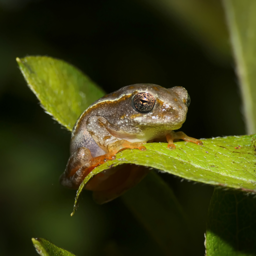

In [ ]:
im = load_image_pil('images/frog.png').resize((256, 256))
im

Creating a SirenGenerator (see the 'Fun with Generators and Losses' bonus notebook):

In [ ]:
gen = SirenGenerator(dim_hidden=32, num_layers=3)

At the moment the output of the generator doesn't look like much:

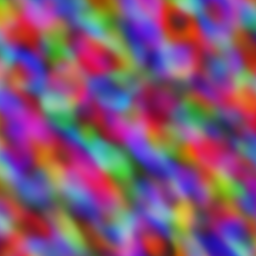

In [ ]:
tensor_to_pil(gen())

Create a loss function that compares an input to a target image, in this case our frog:

In [ ]:
loss = MSELossToTarget(pil_to_tensor(im), size=256)
loss(gen())

tensor(0.1525, grad_fn=<MeanBackward0>)

Optimise the parameters of the generator based on this loss:

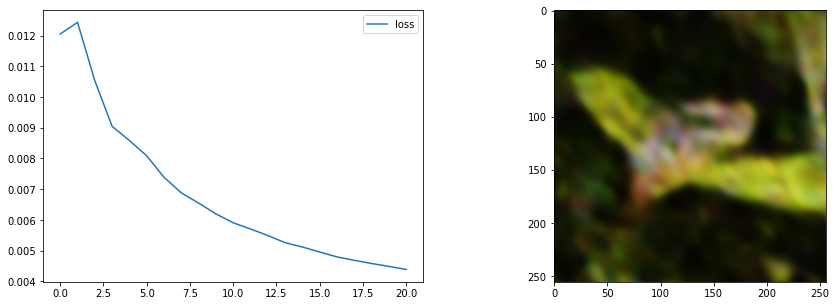

In [ ]:
optimise(gen, [loss], n_steps=30)

And get the result back as a PIL image:

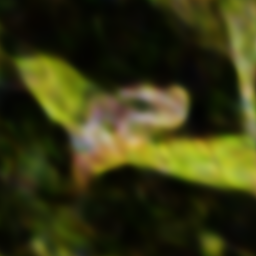

In [ ]:
tensor_to_pil(gen())

OK, so far so good - let's try to serve this process up in an easy-to-use interface.

## Wrapping our code in a function

The first step to turning this into a nice web app is wrapping the above in a nice function:

In [ ]:
from IPython.utils import io

In [ ]:
def sirenify(image, size=256):
    gen = SirenGenerator()
    loss = MSELossToTarget(pil_to_tensor(image), size=int(size))
    with io.capture_output() as captured: # Hide output to keep things clean - remove for debugging
        optimise(gen, [loss], n_steps=30)
    return tensor_to_pil(gen())

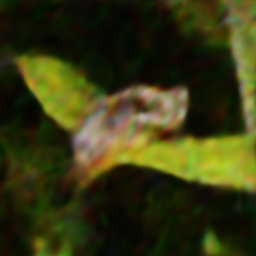

In [ ]:
sirenify(im)

You can see it takes several inputs, each of which we'll be able to set using the gradio interface. In this case we want to return an image, but you can return multiple different outputs (maybe an image, a caption and a confidence score). 

## Making the Gradio Interface

With the defined, we can create the interface like so:

In [ ]:
import gradio as gr

In [ ]:
iface = gr.Interface(fn=sirenify, inputs=[gr.Image(type='pil'), gr.Number(value=256)], outputs=gr.Image())
iface.launch(share=True)

Pretty simple! You should be able to upload an image and click 'Submit', and if all goes well you'll soon see the result in the output tab on the right. For example:

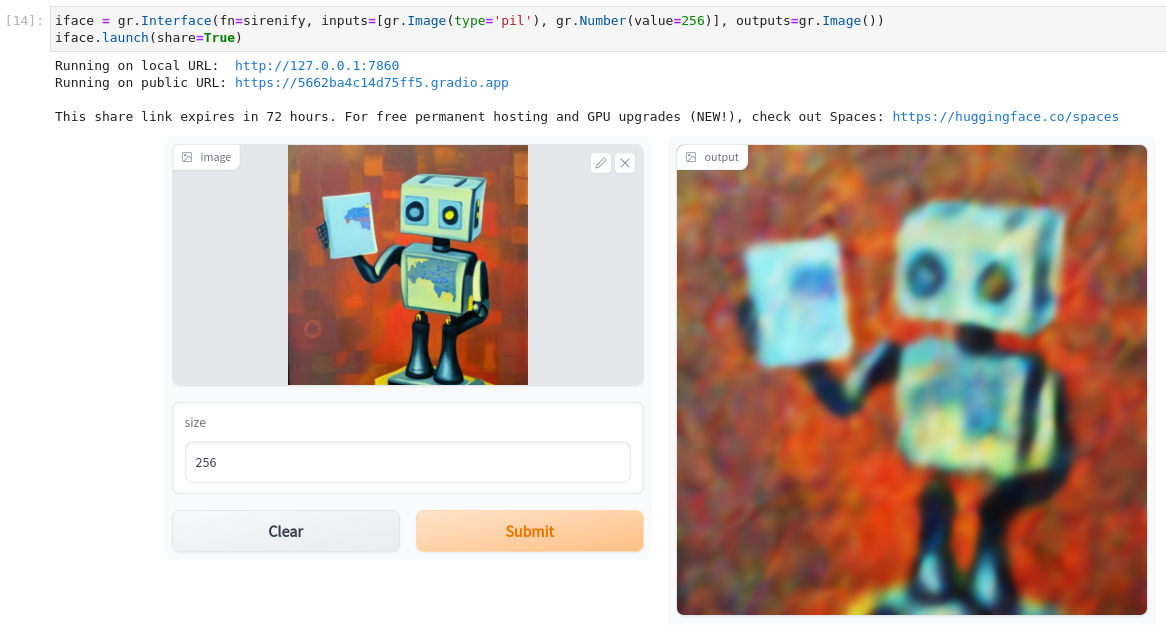

In [ ]:
#|echo: False
load_image_pil('images/gradio_demo_output.png')

## Sharing with the World

In the example above we used `share=True` and got a public URL. You can send this to someone for a quick demo, but the link will expire in 72 hours and the demo is running on your machine. If you want to share your app somewhere more permanent, the easiest option is HuggingFace Spaces.

Getting an app running on there is as simple as packaging up your code into a script and adding requirements to a 'requirements.txt' file. The Gradio docs include some [examples](https://gradio.app/using_hugging_face_integrations/) and there are [plenty of tutorials out there if you get stuck](https://tmabraham.github.io/blog/gradio_hf_spaces_tutorial). However, my favourite resource for seeing how to do this is reading the source code for existing spaces! For any space on the HuggingFace Hub! For example, check out the [stable diffusion space](https://huggingface.co/spaces/stabilityai/stable-diffusion), click on 'Files and Versions' and open app.py to see how they handle a more complex layout with custom styling and a bunch of integrated examples. 

[This excellent guide](https://nbdev.fast.ai/blog/posts/2022-11-07-spaces/) shows how you can take an experiment such as our demo above and export the relevant code straight from a notebook into an app.py file using NBDev. Yet another place where NBDev just seems like magic; I think this is how I will build all my spaces going forward!